# Downloading data

In [1]:
!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/inv_r_test.txt
!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/inv_r_train.txt

!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/enrg_s0_train.txt
!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/enrg_s0_test.txt

!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/jac_train.txt
!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/jac_test.txt

!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/grad_1_train.txt
!wget https://raw.githubusercontent.com/QwanXiong/NN_properties/main/grad_1_test.txt

--2023-06-14 04:04:08--  https://raw.githubusercontent.com/QwanXiong/NN_properties/main/inv_r_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220220 (215K) [text/plain]
Saving to: ‘inv_r_test.txt’

inv_r_test.txt      100%[===================>] 215.06K  --.-KB/s    in 0.03s   

2023-06-14 04:04:08 (8.14 MB/s) - ‘inv_r_test.txt’ saved [220220/220220]

--2023-06-14 04:04:08--  https://raw.githubusercontent.com/QwanXiong/NN_properties/main/inv_r_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1144000 (1.1M) [text/p

# Imports

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from copy import deepcopy

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs)
        loss += criterion(pred, labels)
        #correct += get_correct_count(pred,labels)
       # total += labels.size(0)

    return loss.item() / len(data_loader)

class SSP(torch.nn.Softplus):
    def __init__(self, beta=1, threshold=20):
        super(SSP, self).__init__(beta, threshold)
    def forward(self, input):
        sp0 = torch.nn.functional.softplus(torch.zeros(1), self.beta, self.threshold).item()
        return torch.nn.functional.softplus(input, self.beta, self.threshold) - sp0

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

# Scaling and splitting

In [5]:
inverse_r_dataset_train = np.loadtxt('inv_r_train.txt')
inverse_r_test = np.loadtxt('inv_r_test.txt')

jac_dr_dx_dataset_train = np.loadtxt('jac_train.txt').reshape((4000,15,18))
jac_dr_dx_test = np.loadtxt('jac_test.txt').reshape((770,15,18))

enrg_s0_dataset_train = np.loadtxt('enrg_s0_train.txt')
enrg_s0_test = np.loadtxt('enrg_s0_test.txt')

grad_1_dataset_train = np.loadtxt('grad_1_train.txt')
grad_1_test = np.loadtxt('grad_1_test.txt')

In [6]:
inverse_r_train,inverse_r_val, grad_1_train, grad_1_val, enrg_s0_train,enrg_s0_val,\
jac_dr_dx_train, jac_dr_dx_val = \
 train_test_split(inverse_r_dataset_train,grad_1_dataset_train, enrg_s0_dataset_train,  jac_dr_dx_dataset_train, test_size=0.1,random_state=42)

In [ ]:
inverse_r_train.shape

(3600, 15)

In [7]:
scaler_inv_r = StandardScaler()
scaler_inv_r.fit(inverse_r_train)
inverse_r_scaled_train = scaler_inv_r.transform(inverse_r_train)
inverse_r_scaled_val = scaler_inv_r.transform(inverse_r_val)
inverse_r_scaled_test = scaler_inv_r.transform(inverse_r_test)

scaler_enrg = StandardScaler()
scaler_enrg.fit(enrg_s0_train.reshape(-1,1))
enrg_s0_scaled_train = scaler_enrg.transform(enrg_s0_train.reshape(-1,1))
enrg_s0_scaled_val = scaler_enrg.transform(enrg_s0_val.reshape(-1,1))
enrg_s0_scaled_test = scaler_enrg.transform(enrg_s0_test.reshape(-1,1))

# Model

In [8]:
class FCNet_inv_r(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,50)
        self.fc5 = nn.Linear(50,50)
        self.fc6 = nn.Linear(50,50)
        self.fc7 = nn.Linear(50,50)
        self.fc8 = nn.Linear(50,1)
        self.bn = nn.BatchNorm1d(50)
       # self.lin = nn.Linear(15,1)
        self.activation = SSP()

    def forward(self, x):
       # x = x.view(-1, 3*32*32) # "reshape" image to vector
        x = self.fc1(x)
        res = x
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
       # x = self.bn(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = x + res
        x = self.activation(x)
        x = self.fc6(x)
        #x = self.bn(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x)
        #x = self.lin(x)
        return x


    def calc_grads_train_2(self):
      x = torch.from_numpy(inverse_r_scaled_train)
      x = x.to(device)
      x.requires_grad = True
      output = self.forward(x)
      ext_grad = torch.from_numpy(np.ones(x.shape[0])).reshape(-1,1)
      ext_grad = ext_grad.to(device)
      de_dr   = torch.autograd.grad(outputs=output, inputs=x,\
                                   grad_outputs=ext_grad, retain_graph=True, \
                                   create_graph=True)[0]
      de_dr = de_dr*torch.from_numpy(np.sqrt(scaler_enrg.var_)/np.sqrt(scaler_inv_r.var_)).to(device)
      jac = torch.from_numpy(jac_dr_dx_train)
      jac = jac.to(device)
      de_dx = torch.matmul(de_dr.reshape(x.shape[0],1,15),jac)
      return de_dx
    def calc_grads_test_2(self):
      x = torch.from_numpy(inverse_r_scaled_val)
      x = x.to(device)
      x.requires_grad = True
      output = self.forward(x)
      ext_grad = torch.from_numpy(np.ones(x.shape[0])).reshape(-1,1)
      ext_grad = ext_grad.to(device)
      de_dr   = torch.autograd.grad(outputs=output, inputs=x,\
                                   grad_outputs=ext_grad, retain_graph=True, \
                                   create_graph=True)[0]
      de_dr = de_dr*torch.from_numpy(np.sqrt(scaler_enrg.var_)/np.sqrt(scaler_inv_r.var_)).to(device)
      jac = torch.from_numpy(jac_dr_dx_val)
      jac = jac.to(device)
      de_dx = torch.matmul(de_dr.reshape(x.shape[0],1,15),jac)
      return de_dx

In [9]:
n=3600
best_model = None
best_metrics = np.inf
best_metrics_list = []
numbatch=1
from copy import deepcopy
def train_lbfgs(model, criterion_grad, criterion, optimizer, scheduler, num_epochs=10, tag="cifar10"):
    global best_metrics
    global best_model
    global best_metrics_list
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        #for i in range(numbatch):
            #def closure():

        def closure():


          optimizer.zero_grad()

          grads = (model.calc_grads_train_2())[:,:]
          #print(grads.shape)

          pt = torch.from_numpy(inverse_r_scaled_train[:,:])

          pt = pt.to(device)

        #  pt.requires_grad = True
          targ = torch.from_numpy((enrg_s0_scaled_train[:]))
          targ = targ.to(device)
          targ_grads = torch.from_numpy((grad_1_train[:])).reshape(n,1,18)
          targ_grads = targ_grads.to(device)
          #print(targ_grads.shape)
           # pt.to(torch.float)
            #targ.to(torch.double)
            #targ = ham_s0[i]


          outputs = model(pt)

          #ext_grad = torch.from_numpy(np.ones(pt.shape[0])).reshape(-1,1)
          #de_dr   = torch.autograd.grad(outputs=outputs, inputs=pt,\
             #                      grad_outputs=ext_grad, create_graph=True, retain_graph=True)[0]
          #de_dr =  de_dr*2#/torch.from_numpy(np.sqrt(scaler_enrg.var_)/np.sqrt(scaler_inv_r.var_))/3.0
          #jac = torch.from_numpy(jac_train_dr_dx[:n,:,:])
          #grads = torch.matmul(de_dr.reshape(pt.shape[0],1,15),jac)

          #pt.requires_grad=False

          #if (epoch>10):
          loss = criterion_grad(outputs, targ,grads,targ_grads)
          #else:
           # loss = criterion(outputs, targ)
          loss.backward(retain_graph=True)
         # ep_loss += loss.item()
          #return loss
          return loss.item()

        def calc_loss_train():
          with torch.no_grad():
            pt = torch.from_numpy(inverse_r_scaled_train[:,:])
            pt = pt.to(device)
            targ = torch.from_numpy((enrg_s0_scaled_train[:]))
            targ = targ.to(device)

            outputs = model(pt)
            loss = criterion(outputs, targ)

          return loss.item()

        def calc_loss_test():
          with torch.no_grad():
            pt = torch.from_numpy(inverse_r_scaled_val[:,:])
            pt = pt.to(device)
            targ = torch.from_numpy((enrg_s0_scaled_val[:]))
            targ = targ.to(device)

            outputs = model(pt)
            loss = criterion(outputs, targ)

          return loss.item()


        optimizer.step(closure)


        scheduler.step()

        ep_loss = calc_loss_train()
        # Logging
        #pt = torch.from_numpy(inverse_r_test)
        #targ = torch.from_numpy(ham_s0_test)
        #val_output = model(pt)
        #val_loss = criterion(val_output, targ)
        pp.add_scalar
        pp.add_scalar('loss_train', ep_loss / numbatch)
       # pp.add_scalar('accuracy_train', correct/total)

       # accuracy, loss_val = calaculate_accuracy(model,val_loader,criterion)
        val_loss = calc_loss_test()
        if val_loss < best_metrics:

          #nonlocal best_metrics_list
          #nonlocal best_model
          best_metrics = val_loss
          best_metrics_list.append(best_metrics)
          best_model = deepcopy(model)
          print('Best metrics: ',best_metrics)
        pp.add_scalar('loss_val',val_loss)
        #pp.add_scalar('accuracy_val',accuracy)

        #pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
        pp.display([['loss_train','loss_val']])
    return pp

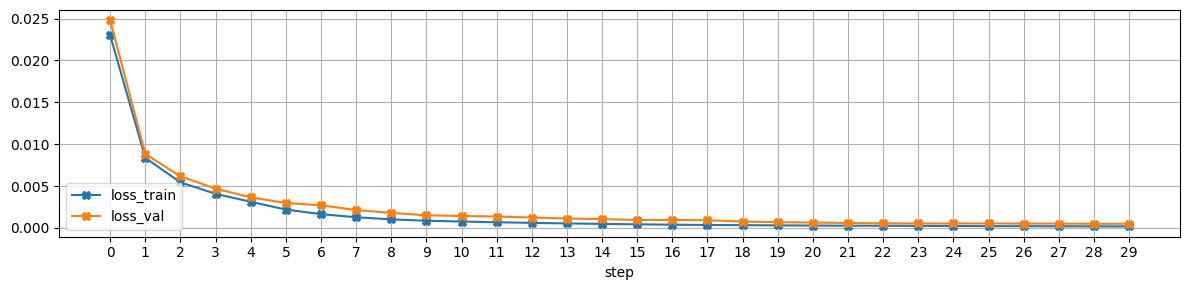

In [11]:
#import random
class loss_grad(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,output,targ,grads,targ_grads):
    #return torch.mean((output-targ)**2 + ((grads-targ_grads)/torch.sqrt(torch.from_numpy(scaler_grad.var_)))**2)
    #print( torch.mean((output-targ)**2),torch.mean((grads-targ_grads)**2))
    return 0.1*torch.mean(((targ)-(output))**2) + torch.mean(((grads)-(targ_grads))**2)


model = FCNet_inv_r()  # Create model instance
#model.train()
model = model.double()
model = model.to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1,weight_decay = 5e-7)  # Weight update
optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-1,history_size=100, line_search_fn='strong_wolfe',max_iter=50,tolerance_grad=1e-6,tolerance_change=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2,step_size=10)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,threshold=1e-4)
criterion = nn.MSELoss() # Loss function
criterion_grad = loss_grad()
pp = train_lbfgs(model, criterion_grad, criterion, optimizer, scheduler, num_epochs=30)

In [12]:
import random
class loss_grad2(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,output,targ,grads,targ_grads):
    rr = random.randint(0,3)

    #print(grads,shape)
    #return torch.mean((output-targ)**2 + ((grads-targ_grads)/torch.sqrt(torch.from_numpy(scaler_grad.var_)))**2)
    #print( torch.mean((output-targ)**2),torch.mean((grads-targ_grads)**2))
    #return 0.0*torch.mean((output-targ)**2) +torch.mean((grads-targ_grads)**2)
    s = torch.tensor(0)
    for i in range(grads.shape[0]):
       tt = targ_grads[i,0]*(-1)**rr
       s = s+torch.min(torch.sum((grads[i,0]-tt)**2),torch.sum((grads[i,0]+tt)**2))
    return s/grads.shape[0]/grads.shape[1]/grads.shape[2]

class loss_grad3(torch.nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,output,targ,grads,targ_grads):
    #print(grads,shape)
    #return torch.mean((output-targ)**2 + ((grads-targ_grads)/torch.sqrt(torch.from_numpy(scaler_grad.var_)))**2)
    #print( torch.mean((output-targ)**2),torch.mean((grads-targ_grads)**2))
    #return 0.0*torch.mean((output-targ)**2) +torch.mean((grads-targ_grads)**2)
    s = torch.tensor(0)
    for i in range(grads.shape[0]):
      for j in range(18):
        for k in range(18):
          s = s+(grads[i,0,j]*grads[i,0,k] -targ_grads[i,0,j]*targ_grads[i,0,k] )**2
      # s = s+torch.min(torch.sum((grads[i,0]-targ_grads[i,0])**2),torch.sum((grads[i,0]+targ_grads[i,0])**2))
    return s/grads.shape[0]/grads.shape[1]/18/18

In [13]:
gr=best_model.calc_grads_train_2( )
gr_test=best_model.calc_grads_test_2( )

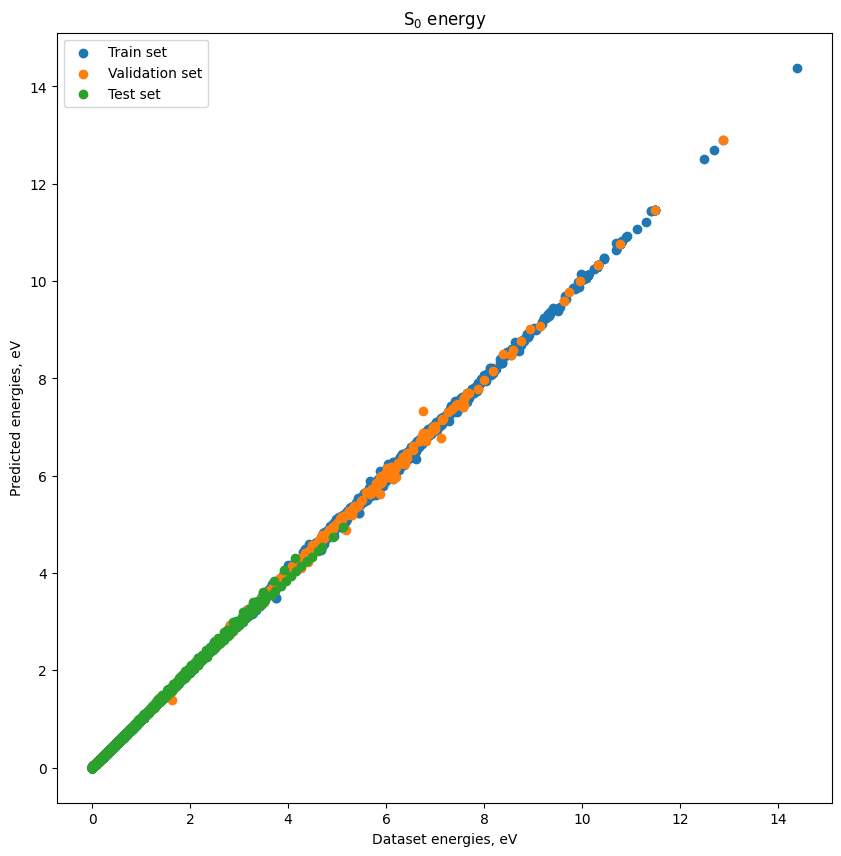

In [14]:
#pred = best_model(torch.from_numpy(inverse_r_scaled_train).to(device))
#pred_val = best_model(torch.from_numpy(inverse_r_scaled_val).to(device))
#pred_test = best_model(torch.from_numpy(inverse_r_scaled_test).to(device))

pred = model(torch.from_numpy(inverse_r_scaled_train).to(device))
pred_val = model(torch.from_numpy(inverse_r_scaled_val).to(device))
pred_test = model(torch.from_numpy(inverse_r_scaled_test).to(device))

pred=pred.cpu().detach().numpy()
pred_val=pred_val.cpu().detach().numpy()
pred_test=pred_test.cpu().detach().numpy()
plt.figure(figsize=(10,10))
#plt.scatter(ham_s0_scaled_train[:3500],pred[:3500])
#plt.scatter(ham_s0_scaled_test[:],pred_test[:])
plt.scatter(scaler_enrg.inverse_transform(enrg_s0_scaled_train[:])*27,scaler_enrg.inverse_transform(pred[:])*27)
plt.scatter(scaler_enrg.inverse_transform(enrg_s0_scaled_val[:])*27,scaler_enrg.inverse_transform(pred_val[:])*27)
plt.scatter(scaler_enrg.inverse_transform(enrg_s0_scaled_test[:])*27,scaler_enrg.inverse_transform(pred_test[:])*27)
plt.title(r"S$_0$ energy")
plt.legend(['Train set','Validation set','Test set'])
plt.xlabel('Dataset energies, eV')
plt.ylabel('Predicted energies, eV')
plt.show()